# Rootzone model: build + rich features + walk-forward
Build master_data, engineer rich features, train RF on anchor intervals, and evaluate per-step.

In [32]:
# Repo paths (works even when notebook is in scripts/)
from pathlib import Path

def find_repo_root(start=None):
    start = Path.cwd() if start is None else Path(start)
    for p in [start, *start.parents]:
        if (p / 'data').exists():
            return p
    return start

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
PLOTS = ROOT / 'plots'
PLOTS.mkdir(exist_ok=True)


In [33]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from datetime import datetime, timedelta, time
import csv
from typing import Any, Dict, List, Optional
from openpyxl import load_workbook
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt



In [34]:
from pathlib import Path
from typing import Optional

def find_repo_root(start: Optional[Path] = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / 'data').exists():
            return parent
    return p

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
# OUTPUTS removed; use PROCESSED or PLOTS
print('ROOT:', ROOT)
print('RAW:', RAW)

def resolve_input(filename: str) -> Path:
    # prefer data/raw; fall back to repo root for backward compatibility
    p1 = RAW / filename
    p2 = PROCESSED / filename
    p3 = ROOT / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    if p3.exists():
        return p3
    raise FileNotFoundError(f'Cannot find {filename} in {RAW} or {ROOT}')


ROOT: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data
RAW: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\raw


In [35]:
# Build master_data from raw files

def floor_to_10min(dt: datetime) -> datetime:
    minute = (dt.minute // 10) * 10
    return dt.replace(minute=minute, second=0, microsecond=0)

def parse_time_flex(text: str) -> time:
    text = text.strip()
    parts = text.split(":")
    if len(parts) >= 2:
        try:
            h = int(parts[0]); m = int(parts[1]); s = int(parts[2]) if len(parts) >= 3 and parts[2] else 0
            return time(hour=h, minute=m, second=s)
        except Exception:
            pass
    for fmt in ("%H:%M:%S", "%H:%M"):
        try:
            return datetime.strptime(text, fmt).time()
        except Exception:
            continue
    raise ValueError(f"Unrecognized time format: {text}")

def parse_ts_variant(text: str, day_first: bool) -> datetime:
    norm = text.replace("-", "/").replace(".", "/").strip()
    if " " not in norm:
        raise ValueError("No space between date and time")
    date_part, time_part = norm.split(" ", 1)
    t_val = parse_time_flex(time_part)
    parts = date_part.split("/")
    if len(parts) < 3:
        raise ValueError("Date part incomplete")
    a, b, y = parts[0], parts[1], parts[2]
    if len(y) == 2:
        y = "20" + y
    if day_first:
        day, month = int(a), int(b)
    else:
        month, day = int(a), int(b)
    return datetime(int(y), month, day, t_val.hour, t_val.minute, t_val.second)

def parse_micro_ts(value: Any, prev_ts: Optional[datetime]) -> datetime:
    if isinstance(value, datetime):
        ts = value
    else:
        text = str(value).strip()
        candidates = []
        for day_first in (True, False):
            try:
                candidates.append(parse_ts_variant(text, day_first))
            except Exception:
                continue
        if not candidates:
            raise ValueError(f"Unrecognized micro-climate timestamp: {value}")
        if prev_ts is not None:
            best = None; best_delta = None
            for dt in candidates:
                delta = dt - prev_ts
                if delta >= timedelta(minutes=-5) and (best_delta is None or delta < best_delta):
                    best = dt; best_delta = delta
            ts = best if best is not None else candidates[0]
        else:
            ts = candidates[0]
    return ts

def parse_time_robust(val: Any) -> time:
    if isinstance(val, datetime):
        return val.time()
    if isinstance(val, time):
        return val
    return parse_time_flex(str(val))

def parse_date_dayfirst(text: str) -> datetime.date:
    text = text.strip()
    norm = text.replace("-", "/").replace(".", "/")
    parts = norm.split("/")
    if len(parts) >= 3:
        d, m, y = parts[0], parts[1], parts[2]
        if len(y) == 2:
            y = "20" + y
        return datetime(int(y), int(m), int(d)).date()
    for fmt in ("%d/%m/%Y", "%d/%m/%y", "%Y-%m-%d"):
        try:
            return datetime.strptime(text, fmt).date()
        except Exception:
            continue
    raise ValueError(f"Unrecognized date format: {text}")

def read_micro(path: str) -> List[Dict[str, Any]]:
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb["micro_climate_rh_t_et0"]
    rows = ws.iter_rows(values_only=True)
    next(rows)
    data = []
    prev_ts = None
    base_ts = None
    interval = timedelta(minutes=10)
    for row in rows:
        if not row or row[0] is None:
            continue
        raw_ts = parse_micro_ts(row[0], prev_ts)
        if base_ts is None:
            base_ts = raw_ts
            seq_ts = base_ts
        else:
            seq_ts = base_ts + interval * len(data)
        prev_ts = raw_ts
        data.append({
            "timestamp": seq_ts,
            "ET0": row[1],
            "internal_air_temp_c": row[2],
            "internal_rh_%": row[3],
            "internal_radiation": row[4],
        })
    return data

def read_irrigation(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    events = []
    for row in rows:
        if not row or row[0] is None:
            continue
        date_val, time_val, irr_ml, fert_type = row[0], row[1], row[2], row[3]
        if isinstance(date_val, datetime):
            date_only = date_val.date()
        else:
            parsed = None
            for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y", "%d.%m.%Y", "%m.%d.%Y"):
                try:
                    parsed = datetime.strptime(str(date_val), fmt).date(); break
                except Exception:
                    continue
            if parsed is None:
                parsed = parse_date_dayfirst(str(date_val))
            date_only = parsed
        t_val = parse_time_robust(time_val)
        dt = datetime.combine(date_only, t_val)
        bucket = floor_to_10min(dt)
        fert_code = 0
        if isinstance(fert_type, str):
            f = fert_type.strip().upper()
            if f == "A":
                fert_code = 1
            elif f == "B":
                fert_code = 2
        events.append({"bucket": bucket, "irr_ml": irr_ml or 0.0, "fert_code": fert_code})
    return events

def build_irrigation_series(events):
    fert_by_bucket = {}
    irr_by_bucket = defaultdict(float)
    for ev in events:
        irr_by_bucket[ev["bucket"]] += ev["irr_ml"]
        if ev["fert_code"]:
            fert_by_bucket[ev["bucket"]] = max(fert_by_bucket.get(ev["bucket"], 0), ev["fert_code"])
    return irr_by_bucket, fert_by_bucket

def parse_ph_ec_date(val: Any) -> Optional[datetime.date]:
    if isinstance(val, datetime):
        return val.date()
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    for sep in (".", "/", "-"):
        if sep in s:
            parts = s.replace("-", sep).replace("/", sep).split(sep)
            if len(parts) >= 3:
                d_raw, m_raw, y_raw = parts[0], parts[1], parts[2]
                for day_first in (True, False):
                    day, month = (d_raw, m_raw) if day_first else (m_raw, d_raw)
                    year = y_raw
                    if len(year) == 2:
                        year = "20" + year
                    try:
                        return datetime(int(year), int(month), int(day)).date()
                    except Exception:
                        continue
    for fmt in ("%Y-%m-%d", "%Y/%m/%d", "%m.%d.%Y", "%d.%m.%Y", "%m-%d-%Y", "%d-%m-%Y"):
        try:
            return datetime.strptime(s, fmt).date()
        except Exception:
            continue
    return None

def read_ph_ec(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    measurements = []
    for row in rows:
        if not row or row[1] is None:
            continue
        date_part = parse_ph_ec_date(row[1])
        time_part = row[4]
        if date_part is None or time_part is None:
            continue
        t_val = parse_time_robust(time_part)
        dt = datetime.combine(date_part, t_val)
        measurements.append({"timestamp": dt, "ph": row[2], "ec_ms": row[3]})
    return measurements

def map_ph_ec_to_micro(timestamps: List[datetime], measurements: List[Dict[str, Any]]):
    ph_list = [None] * len(timestamps)
    ec_list = [None] * len(timestamps)
    for m in measurements:
        best_idx = None; best_diff = None
        for idx, ts in enumerate(timestamps):
            diff = abs(ts - m["timestamp"])
            if diff <= timedelta(minutes=10) and (best_diff is None or diff < best_diff):
                best_idx = idx; best_diff = diff
        if best_idx is not None:
            ph_list[best_idx] = m["ph"]
            ec_list[best_idx] = m["ec_ms"]
    return ph_list, ec_list

def read_soil_temp(path: str):
    data = {}
    with open(path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            ts = datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")
            data[ts] = float(row["soil_temp_pred"]) if row["soil_temp_pred"] != "" else None
    return data

def read_canopy(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    canopy = {}
    for row in rows:
        if len(row) < 7:
            continue
        date_val = row[4]
        canopy_val = row[6]
        if date_val is None:
            continue
        if not isinstance(date_val, datetime):
            try:
                date_val = datetime.strptime(str(date_val), "%Y-%m-%d")
            except Exception:
                continue
        canopy[date_val.date()] = canopy_val
    return canopy

def build_master():
    micro = read_micro(str(resolve_input("micro_climate_rh_t_et0.xlsx")))
    events = read_irrigation(str(resolve_input("Irrigation + ALL Elemental Fractions schedule for one plant (100N).xlsx")))
    irr_by_bucket, fert_by_bucket = build_irrigation_series(events)
    ph_ec = read_ph_ec(str(resolve_input("PH+EC Final.xlsx")))
    soil_temp = read_soil_temp(str(resolve_input("soil_temp_predictions_full_range.csv")))
    canopy = read_canopy(str(resolve_input("Daily Canopy Cover Values.xlsx")))

    timestamps = [row["timestamp"] for row in micro]
    ph_list, ec_list = map_ph_ec_to_micro(timestamps, ph_ec)

    fert_flags = []
    soil_list = []
    canopy_list = []
    irr_current = []

    for i, ts in enumerate(timestamps):
        irr_now = irr_by_bucket.get(ts, 0.0)
        irr_current.append(irr_now)
        fert_flags.append(fert_by_bucket.get(ts, 0))
        soil_list.append(soil_temp.get(ts))
        canopy_list.append(canopy.get(ts.date()))

    df_out = pd.DataFrame({
        "timestamp": timestamps,
        "ET0": [r["ET0"] for r in micro],
        "internal_air_temp_c": [r["internal_air_temp_c"] for r in micro],
        "internal_rh_%": [r["internal_rh_%"] for r in micro],
        "internal_radiation": [r["internal_radiation"] for r in micro],
        "irrigation_ml_current": irr_current,
        "fertilization_flag": fert_flags,
        "ph": ph_list,
        "ec_ms": ec_list,
        "soil_temp_pred": soil_list,
        "canopy_cover": canopy_list,
    })
    df_out = df_out.sort_values("timestamp").set_index("timestamp")
    out_path = PROCESSED / "master_data.csv"
    df_out.to_csv(out_path, index=True)
    print(f"Wrote {out_path} with {len(df_out)} rows")
    return df_out

print("Building master_data ...")
df = build_master()


Building master_data ...
Wrote C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master_data.csv with 16682 rows


In [36]:
# Rich feature engineering on master (10-minute timeline)
pi = np.pi
hours = df.index.hour
days = df.index.dayofyear
dow = df.index.weekday

feat_dict = {}
feat_dict['hour_sin'] = np.sin(2*pi*hours/24)
feat_dict['hour_cos'] = np.cos(2*pi*hours/24)
feat_dict['doy_sin'] = np.sin(2*pi*days/365)
feat_dict['doy_cos'] = np.cos(2*pi*days/365)
feat_dict['dow_sin'] = np.sin(2*pi*dow/7)
feat_dict['dow_cos'] = np.cos(2*pi*dow/7)
feat_dict['is_weekend'] = df.index.weekday.isin([5,6]).astype(int)

idx_series = pd.Series(df.index, index=df.index)
time_since_start_min = (idx_series - idx_series.min()).dt.total_seconds() / 60

# Core realtime features (latest values)
feat_dict['temp_c'] = df['internal_air_temp_c'].ffill().fillna(0)
feat_dict['rh_pct'] = df['internal_rh_%'].ffill().fillna(0)
feat_dict['et0'] = df['ET0'].ffill().fillna(0)
feat_dict['radiation'] = df['internal_radiation'].ffill().fillna(0)
if 'soil_temp_pred' in df.columns:
    feat_dict['soil_temp_c'] = df['soil_temp_pred'].ffill().fillna(0)
if 'canopy_cover' in df.columns:
    canopy_filled = df['canopy_cover'].ffill().fillna(0)
    feat_dict['canopy_cover'] = canopy_filled
    feat_dict['canopy_cover_change_1h'] = canopy_filled.diff(6)
    feat_dict['canopy_cover_slope_1h'] = canopy_filled.diff(6) / 6

# Irrigation / fertigation features
irr_amt = df['irrigation_ml_current'].fillna(0)
irr_flag = (irr_amt > 0).astype(int)
fert_flag = (df['fertilization_flag'].fillna(0) > 0).astype(int)
fert_a = (df['fertilization_flag'] == 1).astype(int)
fert_b = (df['fertilization_flag'] == 2).astype(int)
feat_dict['irrigation_flag'] = irr_flag
feat_dict['fertigation_flag'] = fert_flag
feat_dict['fert_a_flag'] = fert_a
feat_dict['fert_b_flag'] = fert_b
feat_dict['irrigation_ml_current'] = irr_amt

last_irr_time = pd.Series(df.index.where(irr_flag==1), index=df.index).ffill()
last_fert_time = pd.Series(df.index.where(fert_flag==1), index=df.index).ffill()
feat_dict['time_since_irrigation_minutes'] = ((idx_series - last_irr_time).dt.total_seconds() / 60).fillna(time_since_start_min)
feat_dict['time_since_fertigation_minutes'] = ((idx_series - last_fert_time).dt.total_seconds() / 60).fillna(time_since_start_min)
feat_dict['hours_since_irrigation'] = feat_dict['time_since_irrigation_minutes'] / 60
feat_dict['hours_since_fertigation'] = feat_dict['time_since_fertigation_minutes'] / 60
feat_dict['time_since_fertigation'] = feat_dict['hours_since_fertigation']

last_irr_amt = irr_amt.where(irr_flag==1).ffill().fillna(0)
feat_dict['last_irrigation_amount_ml'] = last_irr_amt

fert_amt = None
for cand in ['fertilization_ml_current','fertilization_ml','fert_ml','fertigation_ml']:
    if cand in df.columns:
        fert_amt = df[cand].fillna(0)
        feat_dict['fertigation_ml_current'] = fert_amt
        last_fert_amt = fert_amt.where(fert_amt > 0).ffill().fillna(0)
        feat_dict['last_fertigation_amount_ml'] = last_fert_amt
        break

windows = {6:'1h', 18:'3h', 36:'6h', 144:'24h'}
for win,name in windows.items():
    feat_dict[f'irr_sum_{name}'] = irr_amt.rolling(win, min_periods=1).sum()
    feat_dict[f'irr_flag_count_{name}'] = irr_flag.rolling(win, min_periods=1).sum()
    feat_dict[f'irr_flag_density_{name}'] = feat_dict[f'irr_flag_count_{name}'] / win
    feat_dict[f'fert_count_{name}'] = fert_flag.rolling(win, min_periods=1).sum()
    feat_dict[f'fert_a_count_{name}'] = fert_a.rolling(win, min_periods=1).sum()
    feat_dict[f'fert_b_count_{name}'] = fert_b.rolling(win, min_periods=1).sum()
    feat_dict[f'fert_density_{name}'] = feat_dict[f'fert_count_{name}'] / win
    if fert_amt is not None:
        feat_dict[f'fert_sum_{name}'] = fert_amt.rolling(win, min_periods=1).sum()

feat_dict['irr_cum_ml'] = irr_amt.cumsum()
if fert_amt is not None:
    feat_dict['fert_cum_ml'] = fert_amt.cumsum()
else:
    feat_dict['fert_event_cum'] = fert_flag.cumsum()
feat_dict['fert_event_cum_6h'] = fert_flag.rolling(36, min_periods=1).sum()
feat_dict['fert_event_cum_24h'] = fert_flag.rolling(144, min_periods=1).sum()

# Climate dynamics / trends (avoid roll_min/max duplicates)
climate_cols = ['internal_air_temp_c','internal_rh_%','internal_radiation','ET0']
if 'soil_temp_pred' in df.columns:
    climate_cols.append('soil_temp_pred')

for col in climate_cols:
    base = df[col].ffill().fillna(0)
    for win,name in windows.items():
        feat_dict[f'{col}_roll_mean_{name}'] = base.rolling(win, min_periods=1).mean()
        feat_dict[f'{col}_roll_std_{name}'] = base.rolling(win, min_periods=1).std()
    feat_dict[f'{col}_diff_10m'] = base.diff()
    feat_dict[f'{col}_diff_1h'] = base - base.shift(6)
    feat_dict[f'{col}_slope_1h'] = (base - base.shift(6)) / 6
    feat_dict[f'{col}_slope_3h'] = (base - base.shift(18)) / 18
    roll_30m = base.rolling(3, min_periods=1).mean()
    roll_60m = base.rolling(6, min_periods=1).mean()
    feat_dict[f'{col}_delta_30m_mean'] = base - roll_30m
    feat_dict[f'{col}_delta_60m_mean'] = base - roll_60m

# VPD from temp + RH
# es (kPa) = 0.6108 * exp(17.27*T/(T+237.3)); vpd = es * (1 - RH)
T = df['internal_air_temp_c'].ffill().fillna(0)
RH = df['internal_rh_%'].ffill().fillna(0) / 100.0
es = 0.6108 * np.exp((17.27 * T) / (T + 237.3))
feat_dict['vpd_kpa'] = es * (1 - RH)
feat_dict['vpd_slope_2h'] = (feat_dict['vpd_kpa'] - pd.Series(feat_dict['vpd_kpa'], index=df.index).shift(12)) / 12
feat_dict['vpd_roll_mean_1h'] = pd.Series(feat_dict['vpd_kpa'], index=df.index).rolling(6, min_periods=1).mean()

# Short-horizon sums and balances
et0_series = df['ET0'].ffill().fillna(0)
rad_series = df['internal_radiation'].ffill().fillna(0)
for win,name in {6:'1h', 18:'3h', 36:'6h', 144:'24h'}.items():
    feat_dict[f'et0_sum_{name}'] = et0_series.rolling(win, min_periods=1).sum()
    feat_dict[f'radiation_sum_{name}'] = rad_series.rolling(win, min_periods=1).sum()

feat_dict['water_balance_1h'] = feat_dict['irr_sum_1h'] - feat_dict['et0_sum_1h']
feat_dict['water_balance_3h'] = feat_dict['irr_sum_3h'] - feat_dict['et0_sum_3h']
feat_dict['water_balance_6h'] = feat_dict['irr_sum_6h'] - feat_dict['et0_sum_6h']
feat_dict['water_balance_24h'] = feat_dict['irr_sum_24h'] - feat_dict['et0_sum_24h']

# Extra slopes
feat_dict['ET0_slope_3h'] = (et0_series - et0_series.shift(18)) / 18
if 'soil_temp_pred' in df.columns:
    soil_series = df['soil_temp_pred'].ffill().fillna(0)
    feat_dict['soil_temp_slope_3h'] = (soil_series - soil_series.shift(18)) / 18
    feat_dict['soil_temp_slope_6h'] = (soil_series - soil_series.shift(36)) / 36

# Growth context
days_since_start = (df.index - df.index.min()).total_seconds() / 86400
if 'days_since_planting' in df.columns:
    feat_dict['days_since_planting'] = df['days_since_planting'].ffill().fillna(days_since_start)
else:
    feat_dict['days_since_planting'] = days_since_start

# Interaction features
if 'canopy_cover' in df.columns:
    canopy_raw = df['canopy_cover'].ffill().fillna(0)
    canopy_frac = canopy_raw.where(canopy_raw <= 1.0, canopy_raw / 100.0)
    feat_dict['et0_x_canopy_stress'] = et0_series * (1.0 - canopy_frac)
    feat_dict['irr_to_et0_3h'] = feat_dict['irr_sum_3h'] / (feat_dict['et0_sum_3h'] + 1e-6)
    feat_dict['radiation_x_days'] = rad_series * feat_dict['days_since_planting']
else:
    feat_dict['irr_to_et0_3h'] = feat_dict['irr_sum_3h'] / (feat_dict['et0_sum_3h'] + 1e-6)
    feat_dict['radiation_x_days'] = rad_series * feat_dict['days_since_planting']

feat_df = pd.DataFrame(feat_dict, index=df.index)
# Save full master timeline with engineered features (no filtering on pH/EC)
master_with_features = df.join(pd.DataFrame(feat_dict, index=df.index), lsuffix='_raw', rsuffix='')
master_features_path = PROCESSED / 'master_data_with_features.csv'
master_with_features.to_csv(master_features_path)
print('Saved', master_features_path, 'rows:', len(master_with_features), 'cols:', master_with_features.shape[1])
mask_all = feat_df.notna().all(axis=1)
feat_df = feat_df.loc[mask_all]
df_feat = df.loc[mask_all]
print('feature rows', len(feat_df))



Saved C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master_data_with_features.csv rows: 16682 cols: 159
feature rows 16646


In [37]:
# EC-only feature set (production-grade)
ec_feature_set = [
    'days_since_planting',
    'canopy_cover',
    'doy_sin',
    'doy_cos',
    'soil_temp_pred_roll_mean_24h',
    'ET0_roll_mean_24h',
    'irr_sum_1h',
    'irr_sum_3h',
    'irr_sum_6h',
    'ET0_sum_1h',
    'ET0_sum_3h',
    'ET0_sum_6h',
    'water_balance_1h',
    'water_balance_3h',
    'water_balance_6h',
    'fert_event_cum_6h',
    'fert_event_cum_24h',
    'time_since_fertigation',
    'vpd_roll_mean_1h',
    'radiation_sum_1h',
    'soil_temp_slope_3h',
]
ec_feature_set = [f for f in ec_feature_set if f in feat_df.columns]
selected_features_combined = ec_feature_set
print(f'EC feature set size: {len(ec_feature_set)}')
print(ec_feature_set)


EC feature set size: 18
['days_since_planting', 'canopy_cover', 'doy_sin', 'doy_cos', 'soil_temp_pred_roll_mean_24h', 'ET0_roll_mean_24h', 'irr_sum_1h', 'irr_sum_3h', 'irr_sum_6h', 'water_balance_1h', 'water_balance_3h', 'water_balance_6h', 'fert_event_cum_6h', 'fert_event_cum_24h', 'time_since_fertigation', 'vpd_roll_mean_1h', 'radiation_sum_1h', 'soil_temp_slope_3h']


In [38]:
# Skip selection if a fixed feature set is already provided
if 'selected_features_combined' in globals():
    print('Using pre-defined feature set:', len(selected_features_combined))
else:
    # Quick model-based feature selection (RF importances)
    from sklearn.ensemble import RandomForestRegressor

    top_n = 25  # target number of features
    min_truth_rows = 100  # guardrail

    # Use rows with ground truth
    truth_mask = df['ph'].notna() & df['ec_ms'].notna()
    X_fs = feat_df.loc[truth_mask].copy()
    y_ph = df.loc[truth_mask, 'ph'].astype(float)
    y_ec = df.loc[truth_mask, 'ec_ms'].astype(float)

    if len(X_fs) >= min_truth_rows:
        rf_fs_params = dict(
            n_estimators=200,
            max_depth=10,
            min_samples_leaf=3,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
        )
        rf_ph = RandomForestRegressor(**rf_fs_params)
        rf_ec = RandomForestRegressor(**rf_fs_params)
        rf_ph.fit(X_fs, y_ph)
        rf_ec.fit(X_fs, y_ec)
        imp_ph = pd.Series(rf_ph.feature_importances_, index=X_fs.columns)
        imp_ec = pd.Series(rf_ec.feature_importances_, index=X_fs.columns)

        selected_features_ph = imp_ph.sort_values(ascending=False).head(top_n).index.tolist()
        selected_features_ec = imp_ec.sort_values(ascending=False).head(top_n).index.tolist()
        selected_features_combined = sorted(set(selected_features_ph) | set(selected_features_ec))

        print(f'Selected {len(selected_features_ph)} pH features (top_n={top_n})')
        display(imp_ph.sort_values(ascending=False).head(min(25, len(imp_ph))))
        print(f'Selected {len(selected_features_ec)} EC features (top_n={top_n})')
        display(imp_ec.sort_values(ascending=False).head(min(25, len(imp_ec))))
        print(f'Combined feature set size: {len(selected_features_combined)}')
    else:
        selected_features_ph = list(feat_df.columns)
        selected_features_ec = list(feat_df.columns)
        selected_features_combined = list(feat_df.columns)
        print(f'Not enough truth rows for selection ({len(X_fs)} < {min_truth_rows}). Using all features.')






Using pre-defined feature set: 18


# Realtime 10-minute predictions
Predict pH and EC every 10 minutes starting from the first timestamp with real pH/EC.
At each step, predict; when ground truth exists, report that row's error, then update the model and continue.


In [ ]:
import warnings
# Suppress noisy sklearn parallel warning as early as possible
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings(
    'ignore',
    message=r'sklearn\.utils\.parallel\.delayed should be used with sklearn\.utils\.parallel\.Parallel.*',
    category=UserWarning,
    module=r'sklearn\.utils\.parallel'
)
warnings.filterwarnings('ignore', message='.*sklearn.utils.parallel.delayed.*Parallel.*')

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use engineered features; forward-fill to avoid gaps, no pH/EC leakage.
# Use full engineered feature set for more context; add prev-state features separately.
base_features = selected_features_combined
feature_frame = master_with_features[base_features].copy().ffill().fillna(0)

cols_with_prev = base_features + ['ph_prev', 'ec_prev']
rf_params = dict(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    max_features='sqrt',
    max_samples=0.8,
    random_state=42,
    n_jobs=-1,
)

min_train_points = 20  # require this many true samples before fitting
model = None
X_train_rows, y_train_rows = [], []
X_train_final = None
y_train_final = None
records = []
ph_state = None
ec_state = None

for ts in feature_frame.index:
    # Initialize state on the first available true sample
    if (ph_state is None or ec_state is None) and pd.notna(df.loc[ts, 'ph']) and pd.notna(df.loc[ts, 'ec_ms']):
        ph_state = float(df.loc[ts, 'ph'])
        ec_state = float(df.loc[ts, 'ec_ms'])

    if ph_state is None or ec_state is None:
        continue

    # Build one-row DataFrame with consistent column names
    feature_row = feature_frame.loc[ts].astype(float)
    x_vec = pd.DataFrame([[*feature_row.values, ph_state, ec_state]], columns=cols_with_prev)

    if model is not None:
        pred = model.predict(x_vec)[0]
        ph_pred, ec_pred = float(pred[0]), float(pred[1])
    else:
        ph_pred, ec_pred = ph_state, ec_state  # hold state until trained

    ph_true = df.loc[ts, 'ph']
    ec_true = df.loc[ts, 'ec_ms']
    has_truth = pd.notna(ph_true) and pd.notna(ec_true)

    ph_abs_err = ec_abs_err = None
    if has_truth and model is not None:
        ph_abs_err = abs(ph_pred - float(ph_true))
        ec_abs_err = abs(ec_pred - float(ec_true))
        print(f"{ts}: ph_true={float(ph_true):.3f}, ph_pred={ph_pred:.3f}, ec_true={float(ec_true):.3f}, ec_pred={ec_pred:.3f}, ph_abs_err={ph_abs_err:.3f}, ec_abs_err={ec_abs_err:.3f}")

    records.append({
        'timestamp': ts,
        'ph_pred': ph_pred,
        'ec_pred': ec_pred,
        'ph_true': float(ph_true) if has_truth else None,
        'ec_true': float(ec_true) if has_truth else None,
        'ph_abs_error': ph_abs_err,
        'ec_abs_error': ec_abs_err,
        'trained_points': len(y_train_rows),
        'model_ready': model is not None,
    })

    if has_truth:
        # Update state with truth, then train
        ph_state, ec_state = float(ph_true), float(ec_true)
        X_train_rows.append(x_vec.iloc[0])
        y_train_rows.append([ph_state, ec_state])
        if len(y_train_rows) >= min_train_points:
            base = RandomForestRegressor(**rf_params)
            model = MultiOutputRegressor(base)
            X_df = pd.DataFrame(X_train_rows, columns=cols_with_prev)
            y_df = pd.DataFrame(y_train_rows, columns=['ph', 'ec'])
            model.fit(X_df, y_df)
            X_train_final = X_df.copy()
            y_train_final = y_df.copy()
    else:
        # No truth: propagate prediction as the new state
        ph_state, ec_state = ph_pred, ec_pred

pred_step_df = pd.DataFrame(records).set_index('timestamp')
pred_step_df['gap_minutes'] = pred_step_df.index.to_series().diff().dt.total_seconds().div(60).fillna(0)
print('Timeline predictions:', len(pred_step_df), 'rows')
display(pred_step_df.head(20))

with_truth = pred_step_df.dropna(subset=['ph_true', 'ec_true'])
if len(with_truth) > 0:
    def rmse(a, b):
        return float(np.sqrt(mean_squared_error(a, b)))
    print('\nMetrics on timestamps with ground truth:')
    print('pH MAE', mean_absolute_error(with_truth['ph_true'], with_truth['ph_pred']), 'RMSE', rmse(with_truth['ph_true'], with_truth['ph_pred']), 'R2', r2_score(with_truth['ph_true'], with_truth['ph_pred']))
    print('EC MAE', mean_absolute_error(with_truth['ec_true'], with_truth['ec_pred']), 'RMSE', rmse(with_truth['ec_true'], with_truth['ec_pred']), 'R2', r2_score(with_truth['ec_true'], with_truth['ec_pred']))
    # Relative MAE (%) ignoring zeros
    rel_ph = (with_truth['ph_abs_error'] / with_truth['ph_true'].abs().replace(0, np.nan)) * 100
    rel_ec = (with_truth['ec_abs_error'] / with_truth['ec_true'].abs().replace(0, np.nan)) * 100
    print('pH relative MAE %:', float(rel_ph.mean(skipna=True)))
    print('EC relative MAE %:', float(rel_ec.mean(skipna=True)))
    # Metrics by gap minutes bins
    with_truth['gap_bin'] = pd.qcut(with_truth['gap_minutes'], q=min(4, len(with_truth)), duplicates='drop')
    gap_metrics = []
    for gb, grp in with_truth.groupby('gap_bin'):
        gap_metrics.append({
            'gap_bin': gb,
            'count': len(grp),
            'ph_mae': mean_absolute_error(grp['ph_true'], grp['ph_pred']),
            'ec_mae': mean_absolute_error(grp['ec_true'], grp['ec_pred']),
            'ph_rel_mae_pct': (grp['ph_abs_error'] / grp['ph_true'].abs().replace(0, np.nan) * 100).mean(skipna=True),
            'ec_rel_mae_pct': (grp['ec_abs_error'] / grp['ec_true'].abs().replace(0, np.nan) * 100).mean(skipna=True),
        })
    gap_metrics_df = pd.DataFrame(gap_metrics)
    print('\nMetrics by gap bin:')
    display(gap_metrics_df)
    # Metrics by true value bins
    ph_bins = pd.qcut(with_truth['ph_true'], q=min(4, len(with_truth)), duplicates='drop')
    ec_bins = pd.qcut(with_truth['ec_true'], q=min(4, len(with_truth)), duplicates='drop')
    ph_bin_metrics = with_truth.groupby(ph_bins).apply(lambda g: pd.Series({
        'count': len(g),
        'mae': mean_absolute_error(g['ph_true'], g['ph_pred']),
        'rel_mae_pct': (g['ph_abs_error'] / g['ph_true'].abs().replace(0, np.nan) * 100).mean(skipna=True),
    })).reset_index().rename(columns={'ph_true': 'ph_bin'})
    ec_bin_metrics = with_truth.groupby(ec_bins).apply(lambda g: pd.Series({
        'count': len(g),
        'mae': mean_absolute_error(g['ec_true'], g['ec_pred']),
        'rel_mae_pct': (g['ec_abs_error'] / g['ec_true'].abs().replace(0, np.nan) * 100).mean(skipna=True),
    })).reset_index().rename(columns={'ec_true': 'ec_bin'})
    print('\nMetrics by pH true bins:')
    display(ph_bin_metrics)
    print('\nMetrics by EC true bins:')
    display(ec_bin_metrics)
    display(with_truth[['ph_true', 'ph_pred', 'ph_abs_error', 'ec_true', 'ec_pred', 'ec_abs_error']].head(30))
else:
    print('No timestamps with ground truth were found.')

# Persist predictions to disk to avoid rerun cost
PROCESSED.mkdir(parents=True, exist_ok=True)
pred_csv = PROCESSED / 'rf_rootzone_realtime_predictions.csv'
pred_step_df.to_csv(pred_csv)
print('Saved predictions to', pred_csv)






2025-08-05 14:10:00: ph_true=8.500, ph_pred=7.967, ec_true=2.470, ec_pred=1.221, ph_abs_err=0.533, ec_abs_err=1.249
2025-08-06 10:00:00: ph_true=7.750, ph_pred=7.752, ec_true=1.045, ec_pred=1.266, ph_abs_err=0.002, ec_abs_err=0.221
2025-08-06 16:30:00: ph_true=8.830, ph_pred=8.043, ec_true=2.250, ec_pred=1.452, ph_abs_err=0.787, ec_abs_err=0.798
2025-08-07 10:00:00: ph_true=8.050, ph_pred=7.825, ec_true=2.360, ec_pred=1.364, ph_abs_err=0.225, ec_abs_err=0.996
2025-08-07 13:00:00: ph_true=8.110, ph_pred=7.924, ec_true=2.300, ec_pred=1.510, ph_abs_err=0.186, ec_abs_err=0.790


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-10 08:20:00: ph_true=7.480, ph_pred=8.081, ec_true=2.180, ec_pred=1.573, ph_abs_err=0.601, ec_abs_err=0.607
2025-08-10 15:20:00: ph_true=8.700, ph_pred=8.187, ec_true=4.180, ec_pred=1.743, ph_abs_err=0.513, ec_abs_err=2.437


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-11 08:10:00: ph_true=7.440, ph_pred=8.015, ec_true=3.290, ec_pred=2.031, ph_abs_err=0.575, ec_abs_err=1.259


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-12 08:30:00: ph_true=7.810, ph_pred=7.895, ec_true=1.473, ec_pred=2.178, ph_abs_err=0.085, ec_abs_err=0.705


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-13 11:20:00: ph_true=7.410, ph_pred=7.924, ec_true=2.130, ec_pred=2.039, ph_abs_err=0.514, ec_abs_err=0.091
2025-08-14 12:30:00: ph_true=8.120, ph_pred=7.810, ec_true=2.390, ec_pred=2.074, ph_abs_err=0.310, ec_abs_err=0.316


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-14 16:20:00: ph_true=8.630, ph_pred=8.263, ec_true=2.520, ec_pred=2.181, ph_abs_err=0.367, ec_abs_err=0.339


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-17 08:10:00: ph_true=7.070, ph_pred=8.007, ec_true=1.145, ec_pred=2.264, ph_abs_err=0.937, ec_abs_err=1.119
2025-08-17 12:40:00: ph_true=9.300, ph_pred=7.886, ec_true=2.680, ec_pred=2.034, ph_abs_err=1.414, ec_abs_err=0.646


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-18 08:30:00: ph_true=8.290, ph_pred=7.982, ec_true=1.932, ec_pred=2.177, ph_abs_err=0.308, ec_abs_err=0.245
2025-08-18 14:40:00: ph_true=9.190, ph_pred=8.349, ec_true=2.930, ec_pred=2.118, ph_abs_err=0.841, ec_abs_err=0.812


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-19 12:30:00: ph_true=9.610, ph_pred=8.089, ec_true=1.752, ec_pred=2.175, ph_abs_err=1.521, ec_abs_err=0.423
2025-08-19 17:30:00: ph_true=9.080, ph_pred=8.639, ec_true=1.354, ec_pred=2.295, ph_abs_err=0.441, ec_abs_err=0.941
2025-08-20 12:00:00: ph_true=9.210, ph_pred=8.498, ec_true=0.912, ec_pred=2.092, ph_abs_err=0.712, ec_abs_err=1.180
2025-08-20 12:20:00: ph_true=8.370, ph_pred=8.647, ec_true=0.845, ec_pred=1.959, ph_abs_err=0.277, ec_abs_err=1.114


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-21 13:00:00: ph_true=8.140, ph_pred=8.523, ec_true=0.738, ec_pred=1.956, ph_abs_err=0.383, ec_abs_err=1.218
2025-08-21 15:00:00: ph_true=7.540, ph_pred=8.741, ec_true=0.828, ec_pred=1.867, ph_abs_err=1.201, ec_abs_err=1.039
2025-08-25 09:00:00: ph_true=9.070, ph_pred=8.368, ec_true=0.327, ec_pred=1.712, ph_abs_err=0.702, ec_abs_err=1.385


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-25 16:00:00: ph_true=9.860, ph_pred=8.655, ec_true=0.327, ec_pred=1.556, ph_abs_err=1.205, ec_abs_err=1.229


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-26 12:00:00: ph_true=7.370, ph_pred=8.718, ec_true=0.266, ec_pred=1.237, ph_abs_err=1.348, ec_abs_err=0.971
2025-08-26 16:30:00: ph_true=7.360, ph_pred=8.701, ec_true=0.314, ec_pred=1.194, ph_abs_err=1.341, ec_abs_err=0.880


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-27 11:40:00: ph_true=7.760, ph_pred=8.271, ec_true=0.181, ec_pred=0.983, ph_abs_err=0.511, ec_abs_err=0.802
2025-08-27 14:10:00: ph_true=8.930, ph_pred=8.372, ec_true=0.294, ec_pred=0.868, ph_abs_err=0.558, ec_abs_err=0.574
2025-08-28 13:30:00: ph_true=7.620, ph_pred=8.453, ec_true=0.358, ec_pred=0.711, ph_abs_err=0.833, ec_abs_err=0.353
2025-08-28 15:00:00: ph_true=10.290, ph_pred=8.398, ec_true=0.174, ec_pred=0.680, ph_abs_err=1.892, ec_abs_err=0.506


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-31 08:20:00: ph_true=7.730, ph_pred=8.341, ec_true=0.180, ec_pred=0.682, ph_abs_err=0.611, ec_abs_err=0.502
2025-08-31 12:30:00: ph_true=10.490, ph_pred=8.221, ec_true=0.167, ec_pred=0.586, ph_abs_err=2.269, ec_abs_err=0.419


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-01 08:30:00: ph_true=9.760, ph_pred=8.328, ec_true=0.292, ec_pred=0.485, ph_abs_err=1.432, ec_abs_err=0.193
2025-09-01 12:30:00: ph_true=10.380, ph_pred=8.686, ec_true=0.306, ec_pred=0.388, ph_abs_err=1.694, ec_abs_err=0.082
2025-09-02 08:30:00: ph_true=8.000, ph_pred=8.756, ec_true=0.168, ec_pred=0.433, ph_abs_err=0.756, ec_abs_err=0.265
2025-09-02 15:00:00: ph_true=10.340, ph_pred=8.857, ec_true=0.299, ec_pred=0.366, ph_abs_err=1.483, ec_abs_err=0.067
2025-09-03 09:00:00: ph_true=8.870, ph_pred=8.811, ec_true=0.301, ec_pred=0.363, ph_abs_err=0.059, ec_abs_err=0.062
2025-09-03 15:20:00: ph_true=10.320, ph_pred=9.142, ec_true=0.308, ec_pred=0.312, ph_abs_err=1.178, ec_abs_err=0.004
2025-09-07 08:50:00: ph_true=8.250, ph_pred=9.038, ec_true=0.334, ec_pred=0.372, ph_abs_err=0.788, ec_abs_err=0.038
2025-09-07 15:30:00: ph_true=10.010, ph_pred=9.385, ec_true=0.155, ec_pred=0.300, ph_abs_err=0.625, ec_abs_err=0.146
2025-09-08 09:30:00: ph_true=8.800, ph_pred=9.138, ec_true=0.326, ec

c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-10 07:50:00: ph_true=7.870, ph_pred=9.299, ec_true=0.342, ec_pred=0.283, ph_abs_err=1.429, ec_abs_err=0.059
2025-09-10 11:30:00: ph_true=9.500, ph_pred=9.299, ec_true=0.292, ec_pred=0.286, ph_abs_err=0.201, ec_abs_err=0.006
2025-09-10 13:50:00: ph_true=10.160, ph_pred=9.068, ec_true=0.303, ec_pred=0.633, ph_abs_err=1.092, ec_abs_err=0.330
2025-09-10 15:50:00: ph_true=10.220, ph_pred=9.278, ec_true=0.306, ec_pred=0.522, ph_abs_err=0.942, ec_abs_err=0.216


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-11 07:50:00: ph_true=7.810, ph_pred=9.191, ec_true=0.336, ec_pred=0.288, ph_abs_err=1.381, ec_abs_err=0.048
2025-09-11 11:20:00: ph_true=9.240, ph_pred=8.977, ec_true=0.170, ec_pred=0.307, ph_abs_err=0.263, ec_abs_err=0.137
2025-09-11 13:30:00: ph_true=9.390, ph_pred=9.262, ec_true=0.348, ec_pred=0.461, ph_abs_err=0.128, ec_abs_err=0.113
2025-09-11 14:10:00: ph_true=10.060, ph_pred=9.494, ec_true=0.325, ec_pred=0.424, ph_abs_err=0.566, ec_abs_err=0.099
2025-09-11 17:20:00: ph_true=9.560, ph_pred=9.299, ec_true=0.288, ec_pred=0.299, ph_abs_err=0.261, ec_abs_err=0.011
2025-09-11 18:10:00: ph_true=9.050, ph_pred=9.369, ec_true=0.349, ec_pred=0.294, ph_abs_err=0.319, ec_abs_err=0.055


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-14 08:30:00: ph_true=8.480, ph_pred=8.747, ec_true=0.177, ec_pred=0.329, ph_abs_err=0.267, ec_abs_err=0.152
2025-09-14 11:30:00: ph_true=9.260, ph_pred=9.255, ec_true=0.286, ec_pred=0.275, ph_abs_err=0.005, ec_abs_err=0.011
2025-09-14 12:20:00: ph_true=9.650, ph_pred=9.337, ec_true=0.316, ec_pred=0.278, ph_abs_err=0.313, ec_abs_err=0.038
2025-09-14 15:10:00: ph_true=9.950, ph_pred=9.429, ec_true=0.156, ec_pred=0.419, ph_abs_err=0.521, ec_abs_err=0.263


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-14 18:00:00: ph_true=9.360, ph_pred=9.305, ec_true=0.307, ec_pred=0.285, ph_abs_err=0.055, ec_abs_err=0.022
2025-09-15 08:10:00: ph_true=7.920, ph_pred=8.975, ec_true=0.198, ec_pred=0.293, ph_abs_err=1.055, ec_abs_err=0.095
2025-09-15 12:00:00: ph_true=9.450, ph_pred=9.262, ec_true=0.321, ec_pred=0.347, ph_abs_err=0.188, ec_abs_err=0.026
2025-09-15 14:10:00: ph_true=10.130, ph_pred=9.293, ec_true=0.332, ec_pred=0.484, ph_abs_err=0.837, ec_abs_err=0.152
2025-09-15 15:30:00: ph_true=10.200, ph_pred=9.481, ec_true=0.334, ec_pred=0.436, ph_abs_err=0.719, ec_abs_err=0.102
2025-09-15 17:40:00: ph_true=9.090, ph_pred=9.518, ec_true=0.383, ec_pred=0.435, ph_abs_err=0.428, ec_abs_err=0.052


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-16 06:40:00: ph_true=7.660, ph_pred=9.158, ec_true=0.358, ec_pred=0.432, ph_abs_err=1.498, ec_abs_err=0.074
2025-09-16 08:50:00: ph_true=8.140, ph_pred=8.742, ec_true=0.183, ec_pred=0.380, ph_abs_err=0.602, ec_abs_err=0.197
2025-09-16 10:00:00: ph_true=7.940, ph_pred=8.827, ec_true=0.414, ec_pred=0.320, ph_abs_err=0.887, ec_abs_err=0.094


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-16 12:10:00: ph_true=9.500, ph_pred=8.792, ec_true=0.302, ec_pred=0.343, ph_abs_err=0.708, ec_abs_err=0.041
2025-09-16 13:50:00: ph_true=9.880, ph_pred=9.385, ec_true=0.309, ec_pred=0.366, ph_abs_err=0.495, ec_abs_err=0.057


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-17 08:50:00: ph_true=8.300, ph_pred=8.574, ec_true=0.215, ec_pred=0.322, ph_abs_err=0.274, ec_abs_err=0.107
2025-09-17 11:50:00: ph_true=8.880, ph_pred=9.001, ec_true=0.128, ec_pred=0.322, ph_abs_err=0.121, ec_abs_err=0.194
2025-09-17 13:30:00: ph_true=9.780, ph_pred=9.451, ec_true=0.333, ec_pred=0.337, ph_abs_err=0.329, ec_abs_err=0.004
2025-09-17 15:20:00: ph_true=9.850, ph_pred=9.625, ec_true=0.221, ec_pred=0.334, ph_abs_err=0.225, ec_abs_err=0.113


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-18 07:10:00: ph_true=7.760, ph_pred=8.651, ec_true=0.470, ec_pred=0.316, ph_abs_err=0.891, ec_abs_err=0.154
2025-09-18 09:40:00: ph_true=8.730, ph_pred=8.773, ec_true=0.410, ec_pred=0.302, ph_abs_err=0.043, ec_abs_err=0.108
2025-09-18 10:30:00: ph_true=9.350, ph_pred=8.672, ec_true=0.365, ec_pred=0.321, ph_abs_err=0.678, ec_abs_err=0.044
2025-09-18 12:00:00: ph_true=7.270, ph_pred=8.985, ec_true=0.980, ec_pred=0.324, ph_abs_err=1.715, ec_abs_err=0.656
2025-09-18 13:10:00: ph_true=7.080, ph_pred=8.441, ec_true=0.662, ec_pred=0.400, ph_abs_err=1.361, ec_abs_err=0.262
2025-09-18 14:10:00: ph_true=6.650, ph_pred=9.003, ec_true=0.709, ec_pred=0.439, ph_abs_err=2.353, ec_abs_err=0.270
2025-09-18 15:10:00: ph_true=6.800, ph_pred=8.577, ec_true=0.680, ec_pred=0.483, ph_abs_err=1.777, ec_abs_err=0.197


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-21 06:30:00: ph_true=6.190, ph_pred=8.575, ec_true=0.501, ec_pred=0.473, ph_abs_err=2.385, ec_abs_err=0.028
2025-09-21 07:20:00: ph_true=4.750, ph_pred=7.866, ec_true=4.230, ec_pred=0.682, ph_abs_err=3.116, ec_abs_err=3.548
2025-09-21 08:40:00: ph_true=4.750, ph_pred=8.094, ec_true=4.970, ec_pred=1.052, ph_abs_err=3.344, ec_abs_err=3.918
2025-09-21 10:30:00: ph_true=5.170, ph_pred=7.425, ec_true=4.520, ec_pred=1.514, ph_abs_err=2.255, ec_abs_err=3.006
2025-09-21 11:40:00: ph_true=5.250, ph_pred=7.161, ec_true=4.400, ec_pred=2.008, ph_abs_err=1.911, ec_abs_err=2.392
2025-09-21 13:40:00: ph_true=5.330, ph_pred=6.886, ec_true=4.530, ec_pred=2.260, ph_abs_err=1.556, ec_abs_err=2.270


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-21 15:30:00: ph_true=5.400, ph_pred=7.251, ec_true=3.870, ec_pred=2.603, ph_abs_err=1.851, ec_abs_err=1.267
Timeline predictions: 14601 rows


,ph_pred,ec_pred,ph_true,ec_true,ph_abs_error,ec_abs_error,trained_points,model_ready,gap_minutes
timestamp,,,,,,,,,
2025-06-12 11:50:00,6.71,0.29,6.71,0.29,NaN,NaN,0,False,0.0
2025-06-12 12:00:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:10:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:20:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:30:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:40:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:50:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 13:00:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 13:10:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0



Metrics on timestamps with ground truth:
pH MAE 0.8147709997324014 RMSE 1.0569030980958862 R2 0.34108560466036864
EC MAE 0.5313144226582804 RMSE 0.9182528372312408 R2 0.3843461142310117
pH relative MAE %: 11.476795650830471
EC relative MAE %: 75.02567364798286

Metrics by gap bin:


C:\Users\edene\AppData\Local\Temp\ipykernel_21920\1231049876.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_truth['gap_bin'] = pd.qcut(with_truth['gap_minutes'], q=min(4, len(with_truth)), duplicates='drop')
C:\Users\edene\AppData\Local\Temp\ipykernel_21920\1231049876.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for gb, grp in with_truth.groupby('gap_bin'):


,gap_bin,count,ph_mae,ec_mae,ph_rel_mae_pct,ec_rel_mae_pct
0,"(-0.001, 10.0]",109,0.814771,0.531314,11.476796,75.025674



Metrics by pH true bins:


C:\Users\edene\AppData\Local\Temp\ipykernel_21920\1231049876.py:136: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ph_bin_metrics = with_truth.groupby(ph_bins).apply(lambda g: pd.Series({
C:\Users\edene\AppData\Local\Temp\ipykernel_21920\1231049876.py:141: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ec_bin_metrics = with_truth.groupby(ec_bins).apply(lambda g: pd.Series({


,ph_bin,count,mae,rel_mae_pct
0,"(4.749, 7.65]",28.0,1.239494,27.457597
1,"(7.65, 8.3]",27.0,0.707727,8.450976
2,"(8.3, 9.39]",27.0,0.432766,4.686667
3,"(9.39, 10.49]",27.0,0.863368,8.393883



Metrics by EC true bins:


,ec_bin,count,mae,rel_mae_pct
0,"(0.127, 0.302]",28.0,0.219339,120.534849
1,"(0.302, 0.36]",27.0,0.212911,67.825674
2,"(0.36, 1.045]",27.0,0.402177,57.307047
3,"(1.045, 4.97]",27.0,1.302385,42.962232


,ph_true,ph_pred,ph_abs_error,ec_true,ec_pred,ec_abs_error
timestamp,,,,,,
2025-06-12 11:50:00,6.71,6.710000,NaN,0.2900,0.290000,NaN
2025-06-29 12:10:00,8.20,6.710000,NaN,0.2900,0.290000,NaN
2025-07-07 11:00:00,7.11,8.200000,NaN,0.3610,0.290000,NaN
2025-07-16 14:00:00,6.75,7.110000,NaN,0.3870,0.361000,NaN
2025-07-20 12:50:00,6.86,6.750000,NaN,0.5200,0.387000,NaN
2025-07-23 11:30:00,6.81,6.860000,NaN,0.3250,0.520000,NaN
2025-07-23 17:30:00,8.14,6.810000,NaN,0.3605,0.325000,NaN
2025-07-24 11:00:00,9.49,8.140000,NaN,0.5821,0.360500,NaN
2025-07-24 15:10:00,9.22,9.490000,NaN,0.5503,0.582100,NaN


Saved predictions to C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\rf_rootzone_realtime_predictions.csv
Saved training matrices to processed directory


## Feature importance (final model)


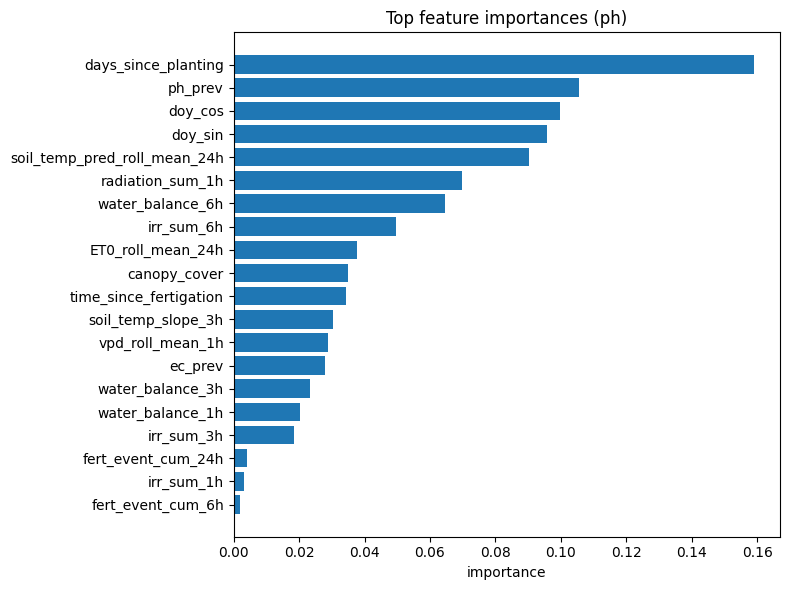

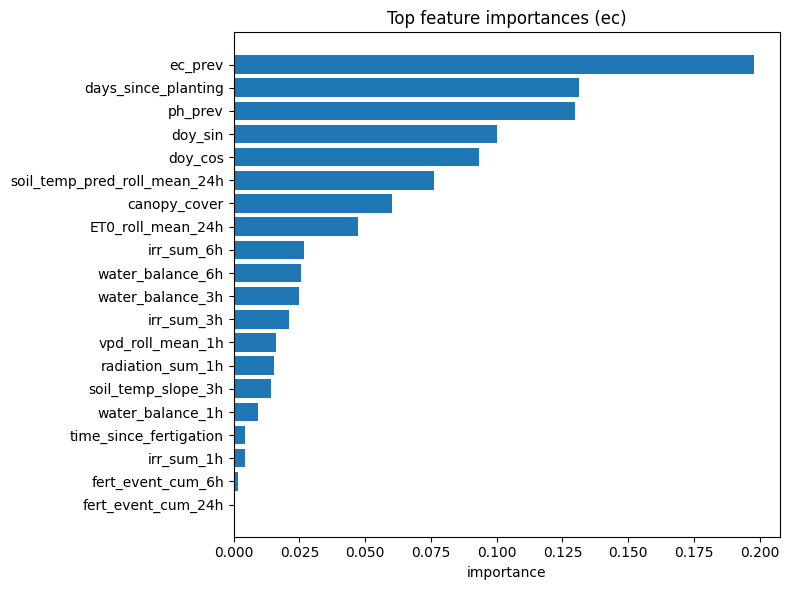

In [40]:
if model is None or X_train_final is None:
    print('No trained model available for importances.')
else:
    import matplotlib.pyplot as plt
    for tgt_name, est in zip(['ph','ec'], model.estimators_):
        imp = pd.Series(est.feature_importances_, index=cols_with_prev).sort_values(ascending=False)
        top = imp.head(25)
        plt.figure(figsize=(8,6))
        plt.barh(top.index[::-1], top.values[::-1])
        plt.title(f'Top feature importances ({tgt_name})')
        plt.xlabel('importance')
        plt.tight_layout()
        plt.show()


## SHAP (final model)


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


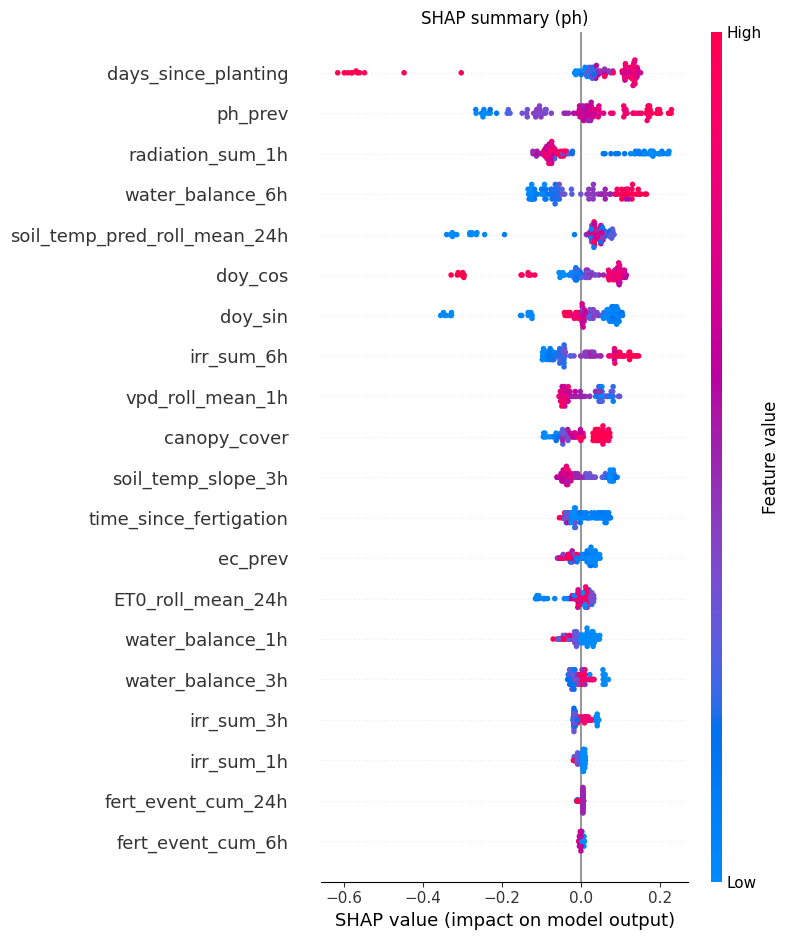

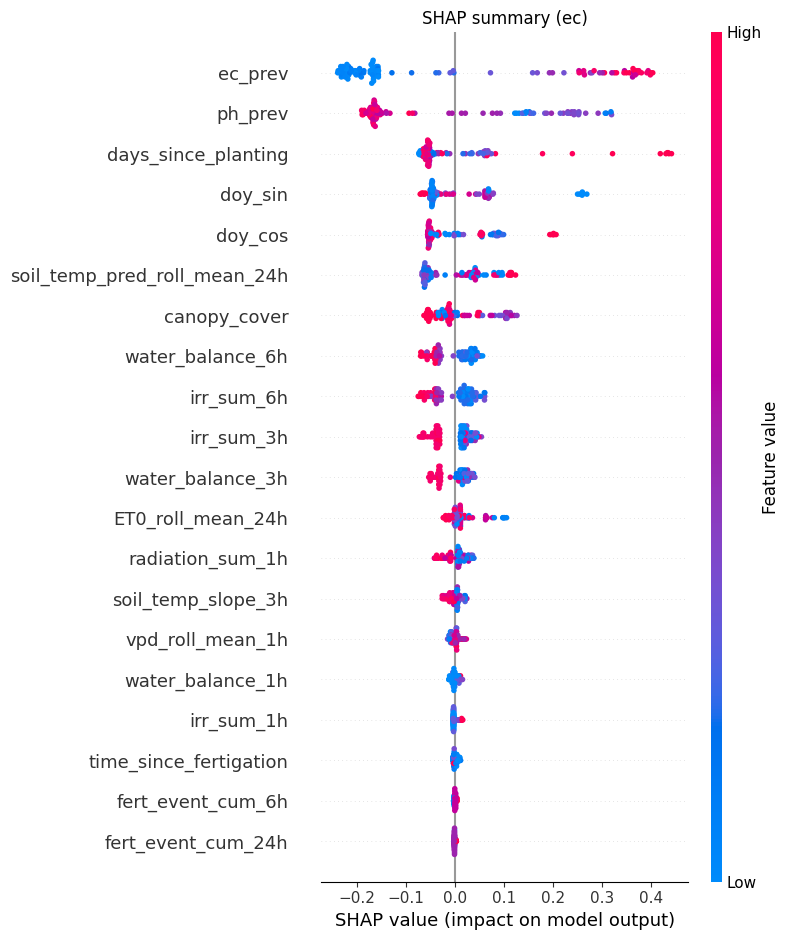

In [41]:
try:
    import shap
except ImportError as e:
    print('shap is not installed. Install with: pip install shap')
    shap = None

if shap is None or model is None or X_train_final is None:
    pass
else:
    sample = X_train_final.sample(n=min(400, len(X_train_final)), random_state=42)
    for tgt_name, est in zip(['ph','ec'], model.estimators_):
        explainer = shap.TreeExplainer(est)
        shap_values = explainer.shap_values(sample)
        shap.summary_plot(shap_values, sample, show=False)
        import matplotlib.pyplot as plt
        plt.title(f'SHAP summary ({tgt_name})')
        plt.tight_layout()
        plt.show()
